# Creating a training dataset by applying a rule-based model to a set of texts

In [62]:
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from spacy.tokens import DocBin
from spacy import displacy
import json
import os
import re
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import warnings
import xmltodict
from datetime import datetime
import time
from tqdm import tqdm

%reload_ext autoreload
%autoreload 2
import datahelper as dt

### Creating labeled vocabulary in json format

In [2]:
dir_path = f"{os.getcwd()}\\data_txt"
txt_files = [f for f in os.listdir(dir_path) if f.endswith(".txt")]

for file in tqdm(txt_files):
    dt.upgrade_data(f"data_txt/{file}")
    dt.delete_dublicates(f"data_txt/{file}")
    with open (f"data_txt/{file}", "r", encoding="utf-8") as f:
        names = []
        for line in f.readlines():
            if line.strip() != '':
                names.append(line.strip())
        names = list(set(names))
    dt.save_data(f"data_json/{file[:-4]}.json", names)

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:07<00:00,  3.14it/s]


In [4]:
labels = {"anxiety":"ANXIETY DISORDERS", 
          'bipolar':'BIPOLAR DISORDERS', 
          'depressive':"DEPRESSIVE DISORDERS", 
          'dissociative': "DISSOCIATIVE DISORDERS", 
          'drugs': "PSYCHEDELIC DRUGS", 
          'eating':"EATING DISORDERS", 
          'neurocog':"NEURO-COGNITIVE DISORDERS",
          'neurodev':"NEURO-DEVELOPMENTAL DISORDERS", 
          'nonsubstance':"NON-SUBSTANCE RELATED DISORDERS", 
          'ocd':"OBSESSIVE-COMPULSIVE AND RELATED DISORDERS", 
          'other':"OTHER DISORDERS", 
          'paraphilias':"PARAPHILIAS",  
          'personality':"PERSONALITY DISORDERS", 
          'schizophrenia':"SCHIZOPHRENIA SPECTRUM AND OTHER PSYCHOTIC DISORDERS", 
          'sexual':"SEXUAL DYSFUNCTIONS", 
          'sleep':"SLEEP-WAKE DISORDERS", 
          'somatic':"SOMATIC SYMPTOM RELATED DISORDERS", 
          'substance':"SUBSTANCE-RELATED DISORDERS", 
          'trauma':"TRAUMA AND STRESS RELATED DISORDERS",
          'elimination':"ELIMINATION DISORDERS",
          'disruptive':"DISRUPTIVE IMPULSE-CONTROL, AND CONDUCT DISORDERS",
          'symptoms':'SYMPTOMS'}

In [63]:
patterns = []
for file in tqdm(txt_files):
    patterns = dt.create_training_data(patterns, f"data_json/{file[:-4]}.json", labels[file[:-4]])
dt.generate_rules(patterns)

100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1933.43it/s]


### Testing on a test sample

In [64]:
test="""After a decades-long pause, psychedelics are again being intensely investigated for treating a wide range of 
        neuropsychiatric ailments including depression, anxiety, addiction, post-traumatic stress disorder, anorexia, 
        and chronic pain syndromes. The classic serotonergic psychedelics psilocybin and lysergic acid diethylamide and 
        nonclassic psychedelics 3,4-methylenedioxymethamphetamine and ketamine are increasingly appreciated as neuroplastogens 
        given their potential to fundamentally alter mood and behavior well beyond the time window of measurable exposure. 
        Imaging studies with psychedelics are also helping advance our understanding of neural networks and connectomics. 
        This resurgence in psychedelic science and psychedelic-assisted therapy has potential significance for the fields of 
        neurosurgery and neuro-oncology and their diverse and challenging patients, many of whom continue to have mental health 
        issues and poor quality of life despite receiving state-of-the-art care. In this study, we review recent and ongoing 
        clinical trials, the set and setting model of psychedelic-assisted therapy, potential risks and adverse events, proposed 
        mechanisms of action, and provide a perspective on how the safe and evidence-based use of psychedelics could potentially 
        benefit many patients, including those with brain tumors, pain syndromes, ruminative disorders, stroke, SAH, TBI, and 
        movement disorders. By leveraging psychedelics' neuroplastic potential to rehabilitate the mind and brain, novel 
        treatments may be possible for many of these patient populations, in some instances working synergistically with current 
        treatments and in some using subpsychedelic doses that do not require mind-altering effects for efficacy. This review aims 
        to encourage broader multidisciplinary collaboration across the neurosciences to explore and help realize the transdiagnostic 
        healing potential of psychedelics."""
test = re.sub("[\n ]+", " ", test)

In [65]:
nlp = spacy.load("annotation_ner")
doc = nlp(test)

options = dt.pretty_colors()
spacy.displacy.render(doc, style="ent", jupyter=True, options=options)

### Geting more training samples from pubmed using entrez pubmed api

In [13]:
db = "pubmed"
domain = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "json"

PMIDs = []
stats = {}
queries = []

for year in range(1963,2024):
    queries.append(f'(psychedelic anxiety depression) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')


for query in tqdm(queries):
    nb = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        nb += 1
        PMIDs.append(id)
    stats[query[40:44]] = nb
PMIDs = list(set(PMIDs))
len(PMIDs)

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:52<00:00,  1.17it/s]


561

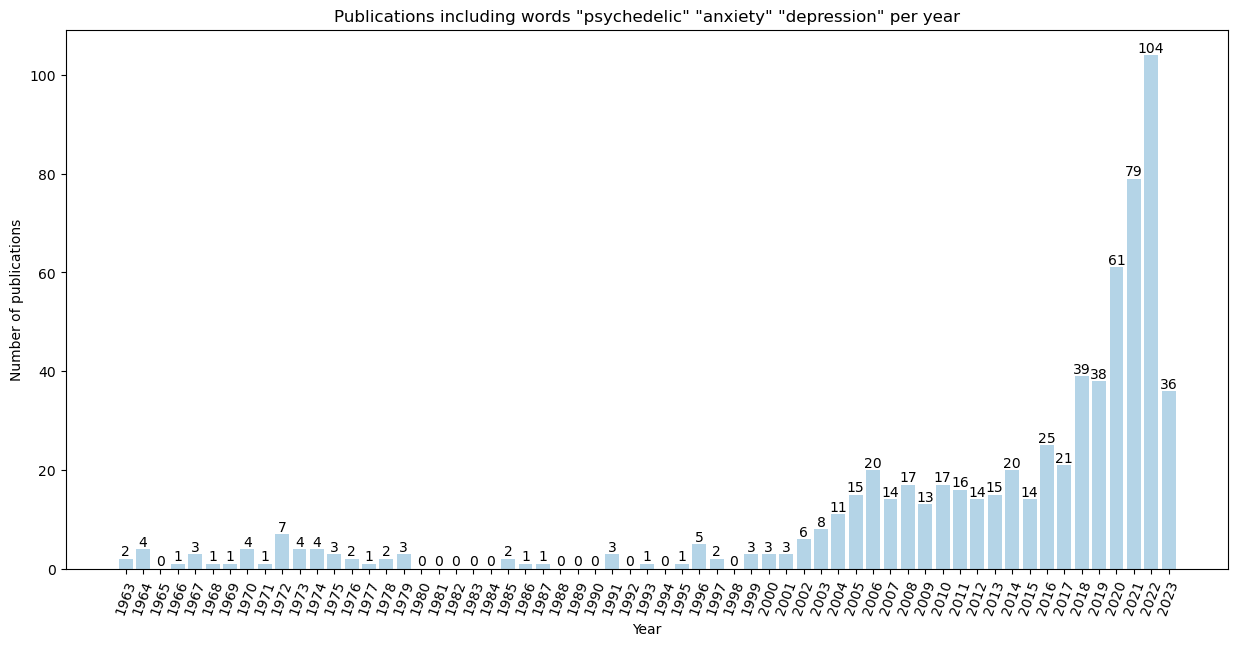

In [14]:
years = list(stats.keys())
values = list(stats.values())

fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(years, values, color='#B4D4E7')

ax.set_xlabel('Year')
ax.set_ylabel('Number of publications')
ax.set_title('Publications including words "psychedelic" "anxiety" "depression" per year')

for i, value in enumerate(values):
    ax.text(i, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=70)

plt.show()

I will devide 561 article into train and test set so that in train set there will be 2/3 * 561 = 374 texts and in test set the ret texts

In [15]:
abstracts = []

count = 0
for PMID in tqdm(PMIDs[:374]):
    count += 1
    if count % 10 == 0:
        time.sleep(1)
        
    summary = dt.get_summary(PMID)
    abstract = dt.get_abstract_from_summary(summary)
    
    abstracts.append(abstract)


  1%|█                                                                                 | 5/374 [00:03<04:01,  1.53it/s]

No abstract


  2%|█▉                                                                                | 9/374 [00:06<03:53,  1.56it/s]

No abstract


  6%|████▊                                                                            | 22/374 [00:16<05:02,  1.16it/s]

No abstract


  7%|██████                                                                           | 28/374 [00:20<03:44,  1.54it/s]

No abstract


  8%|██████▎                                                                          | 29/374 [00:21<03:40,  1.57it/s]

No abstract


 16%|████████████▌                                                                    | 58/374 [00:44<04:14,  1.24it/s]

No abstract


 18%|██████████████▉                                                                  | 69/374 [00:52<03:21,  1.52it/s]

No abstract


 20%|███████████████▊                                                                 | 73/374 [00:55<03:31,  1.42it/s]

No abstract


 22%|██████████████████▏                                                              | 84/374 [01:04<03:22,  1.43it/s]

No abstract


 25%|███████████████████▉                                                             | 92/374 [01:11<03:49,  1.23it/s]

No abstract


 26%|████████████████████▊                                                            | 96/374 [01:13<03:03,  1.52it/s]

No abstract


 28%|██████████████████████▏                                                         | 104/374 [01:19<03:05,  1.46it/s]

No abstract


 32%|█████████████████████████▋                                                      | 120/374 [01:31<03:47,  1.11it/s]

No abstract


 35%|███████████████████████████▊                                                    | 130/374 [01:39<04:09,  1.02s/it]

No abstract


 35%|████████████████████████████▏                                                   | 132/374 [01:40<03:15,  1.24it/s]

No abstract


 36%|█████████████████████████████                                                   | 136/374 [01:42<02:37,  1.51it/s]

No abstract


 37%|█████████████████████████████▌                                                  | 138/374 [01:44<02:30,  1.56it/s]

No abstract


 42%|█████████████████████████████████▎                                              | 156/374 [01:57<02:27,  1.48it/s]

No abstract


 42%|█████████████████████████████████▊                                              | 158/374 [01:58<02:16,  1.58it/s]

No abstract


 44%|██████████████████████████████████▊                                             | 163/374 [02:02<02:30,  1.40it/s]

No abstract


 44%|███████████████████████████████████▌                                            | 166/374 [02:04<02:13,  1.56it/s]

No abstract


 45%|████████████████████████████████████▏                                           | 169/374 [02:06<02:13,  1.54it/s]

No abstract


 48%|██████████████████████████████████████▌                                         | 180/374 [02:15<02:53,  1.12it/s]

No abstract


 54%|███████████████████████████████████████████▏                                    | 202/374 [02:31<02:11,  1.31it/s]

No abstract


 57%|█████████████████████████████████████████████▎                                  | 212/374 [02:38<02:15,  1.19it/s]

No abstract


 57%|█████████████████████████████████████████████▌                                  | 213/374 [02:39<02:02,  1.31it/s]

No abstract


 59%|██████████████████████████████████████████████▊                                 | 219/374 [02:43<01:42,  1.51it/s]

No abstract


 64%|██████████████████████████████████████████████████▉                             | 238/374 [02:57<01:23,  1.62it/s]

No abstract


 73%|██████████████████████████████████████████████████████████▍                     | 273/374 [03:21<01:08,  1.48it/s]

No abstract


 74%|███████████████████████████████████████████████████████████                     | 276/374 [03:23<01:03,  1.54it/s]

No abstract


 77%|█████████████████████████████████████████████████████████████▊                  | 289/374 [03:32<00:52,  1.61it/s]

No abstract


 78%|██████████████████████████████████████████████████████████████▏                 | 291/374 [03:35<01:07,  1.23it/s]

No abstract


 79%|███████████████████████████████████████████████████████████████                 | 295/374 [03:37<00:57,  1.38it/s]

No abstract


 87%|█████████████████████████████████████████████████████████████████████▎          | 324/374 [04:00<00:36,  1.35it/s]

No abstract


 90%|████████████████████████████████████████████████████████████████████████        | 337/374 [04:09<00:22,  1.62it/s]

No abstract


 92%|█████████████████████████████████████████████████████████████████████████▌      | 344/374 [04:14<00:21,  1.37it/s]

No abstract


 93%|██████████████████████████████████████████████████████████████████████████      | 346/374 [04:16<00:21,  1.32it/s]

No abstract


 93%|██████████████████████████████████████████████████████████████████████████▏     | 347/374 [04:17<00:20,  1.32it/s]

No abstract


 99%|███████████████████████████████████████████████████████████████████████████████▎| 371/374 [04:35<00:02,  1.20it/s]

No abstract


100%|███████████████████████████████████████████████████████████████████████████████▊| 373/374 [04:36<00:00,  1.44it/s]

No abstract


100%|████████████████████████████████████████████████████████████████████████████████| 374/374 [04:36<00:00,  1.35it/s]


In [16]:
abstracts_valid = []

count = 0
for PMID in tqdm(PMIDs[374:]):
    count += 1
    if count % 10 == 0:
        time.sleep(1)
        
    summary = dt.get_summary(PMID)
    abstract = dt.get_abstract_from_summary(summary)
    
    abstracts_valid.append(abstract)

  8%|██████▍                                                                          | 15/187 [00:10<01:58,  1.45it/s]

No abstract


 11%|█████████                                                                        | 21/187 [00:14<02:15,  1.23it/s]

No abstract


 12%|█████████▌                                                                       | 22/187 [00:15<02:01,  1.35it/s]

No abstract


 14%|███████████▋                                                                     | 27/187 [00:19<02:36,  1.02it/s]

No abstract


 17%|█████████████▊                                                                   | 32/187 [00:24<02:18,  1.12it/s]

No abstract


 31%|█████████████████████████                                                        | 58/187 [00:42<01:14,  1.74it/s]

No abstract


 44%|███████████████████████████████████▉                                             | 83/187 [01:00<01:12,  1.43it/s]

No abstract


 79%|███████████████████████████████████████████████████████████████▎                | 148/187 [01:47<00:22,  1.75it/s]

No abstract


 80%|████████████████████████████████████████████████████████████████▏               | 150/187 [01:49<00:33,  1.10it/s]

No abstract


 82%|█████████████████████████████████████████████████████████████████▉              | 154/187 [01:52<00:22,  1.49it/s]

No abstract


 93%|██████████████████████████████████████████████████████████████████████████▍     | 174/187 [02:06<00:08,  1.49it/s]

No abstract


 96%|████████████████████████████████████████████████████████████████████████████▌   | 179/187 [02:09<00:04,  1.63it/s]

No abstract


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [02:15<00:00,  1.38it/s]


In [66]:
nlp = spacy.load("annotation_ner")
TRAIN_DATA = []
for abstract in tqdm(abstracts):
    if abstract != None and abstract != '' and abstract != ' ' and abstract != '\n':
        #dt.test_model(nlp, abstract, 'test.txt')
        result = dt.test_model(nlp, abstract)
        if result != None:
            TRAIN_DATA.append(result)
len(TRAIN_DATA)

100%|███████████████████████████████████████████████████████████████████████████████| 374/374 [00:01<00:00, 296.31it/s]


334

In [68]:
TRAIN_DATA[25]

['Abolishment of anxiolytic-like effects of diazepam occurs during re-exposure to some animal tests of anxiety. We investigated the loss of anxiolytic-like effects of diazepam during Trial 2 on previously undrugged mice, namely one-trial tolerance (OTT). Swiss mice were subjected to 1) Four-Plate Test (FPT) without punishments in Trial 1 or 2) FPT without punishments in both Trials or 3) FPT with spatial modifications in Trial 1 or 4) Elevated Plus Maze (EPM), then 24 h later to FPT, with saline, diazepam (1 mg/kg) or DOI (1 mg/kg). Removing punishments in Trial 1 does not counteract the effect reduction of diazepam in Trial 2, but spatial modifications of the aversive environment. Previous exposure to EPM does not trigger a loss of efficacy of diazepam in FPT. Electric punishments do not trigger OTT to benzodiazepines; whilst knowledge of the environment seems to be responsible for this phenomenon. FPT may be useful to study OTT because punishments potentate OTT in this model of anxie

In [35]:
dt.save_data("data/train_data.json", TRAIN_DATA)

In [69]:
nlp = spacy.load("annotation_ner")
TEST_DATA = []
for abstract in tqdm(abstracts_valid):
    if abstract != None and abstract != '' and abstract != ' ' and abstract != '\n':
        result = dt.test_model(nlp, abstract)
        if result != None:
            TEST_DATA.append(result)
len(TEST_DATA)

100%|███████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 214.78it/s]


175

In [70]:
TEST_DATA[25]

["Young adults' Ecstasy use trajectories have important implications for individual and population-level consequences of Ecstasy use, but little relevant research has been conducted. This study prospectively examines Ecstasy trajectories in a population-based sample. Data are from the Natural History Study of Drug Use, a retrospective/prospective cohort study conducted in Australia. Population screening identified a probability sample of Ecstasy users aged 19-23 years. Complete data for 30 months of follow-up, comprising 4 time intervals, were available for 297 participants (88.4% of sample). Trajectories were derived using cluster analysis based on recent Ecstasy use at each interval. Trajectory predictors were examined using a generalized ordered logit model and included Ecstasy dependence (World Mental Health Composite International Diagnostic Instrument), psychological distress (Hospital Anxiety Depression Scale), aggression (Young Adult Self Report) and contextual factors (e.g. at

In [71]:
dt.save_data("data/test_data.json", TEST_DATA)

In [72]:
nlp = spacy.blank("en")
def v3_train(TRAIN_DATA):
    for item in tqdm(TRAIN_DATA):
        try:
            text, annot = item
            doc = nlp.make_doc(text)
            ents = []
            for start, end, label in annot["entities"]:
                span = doc.char_span(start, end, label=label, alignment_mode="contract")
                if span is None:
                    print("Skipping entity")
                else:
                    ents.append(span)
            doc.ents = ents
            db = DocBin()
            db.add(doc)
        except ValueError:
            continue
    return db

In [73]:
TRAIN_DATA = v3_train(TRAIN_DATA)
TRAIN_DATA.to_disk("data/train.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 334/334 [00:01<00:00, 190.68it/s]


In [74]:
TEST_DATA = v3_train(TEST_DATA)
TEST_DATA.to_disk("data/test.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 198.80it/s]
